In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import tarfile
from six.moves import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [2]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


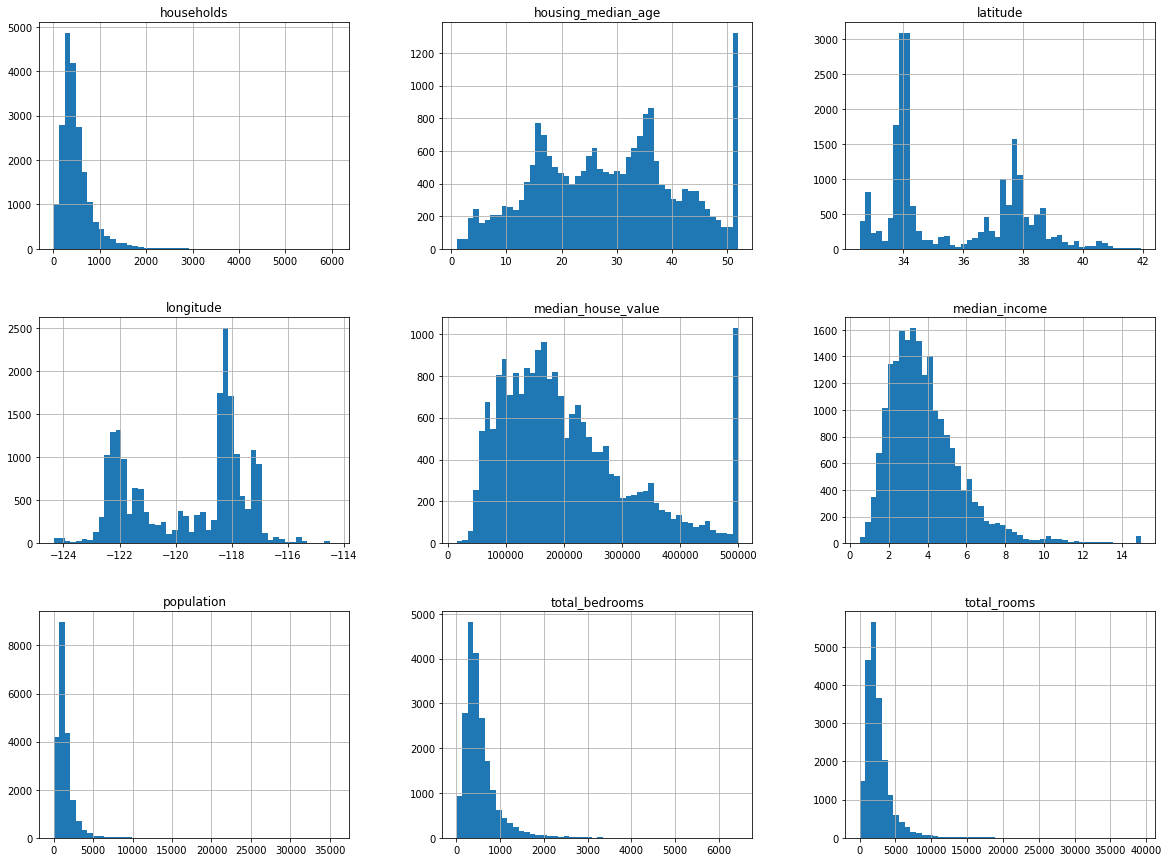

In [15]:
### 读取初始数据 ###
housing = load_housing_data(r"/Users/i328815/Documents/Notes_HandsOn_ML/datasets")

#head()方法简单看表头和前几行
housing.head()

#The info() method is useful to get a quick description of the data
#housing.info()

#检查这一列每个枚举值的个数
#housing["ocean_proximity"].value_counts()

#describe() method shows a summary of the numerical attributes
#housing.describe()

#展示每一列的直方图
housing.hist(bins=50, figsize=(20,15))
pyplot.show()

In [4]:
#根据收入将数据分层(稍后抽样用)
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
#print(housing["income_cat"].value_counts() / len(housing)) #数据总体分层情况
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_train_set = None
strat_test_set = None
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

#去掉用于分层的income_cat这列
for set in (strat_test_set, strat_train_set):
    set.drop(["income_cat"], axis=1, inplace=True)  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Visualizing Geographical Data 

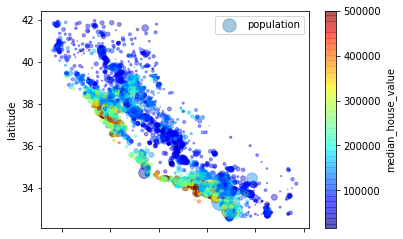

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [5]:
housing = strat_train_set.copy()
# P104 
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.show()
housing.info()

# Looking for Correlations

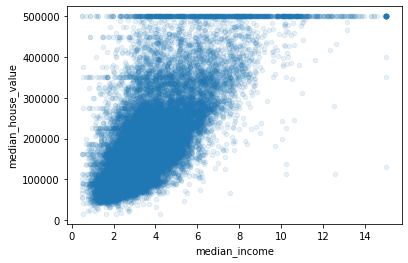

In [19]:
#corr_matrix = housing.corr()
#print(corr_matrix["median_house_value"].sort_values(ascending=False))

#attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
#scatter_matrix(housing[attributes], figsize=(12, 8))
#plt.show()

#median_income 和 median_house_value 强相关
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)
plt.show()

# Experimenting with Attribute Combinations

In [7]:
housing["rooms_per_household"]      = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]        = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


# Prepare the Data for Machine Learning Algorithms

In [8]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_label = strat_train_set["median_house_value"].copy()

In [20]:
#数字类型数值缺失的用平均数补上
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

# replacing missing values by the learned medians
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#Handling Text and Categorical Attributes
# P117  from text categories to integer then from integer to one-hot vectors) in one shot using 
encoder_bin = LabelBinarizer()
housing_cat = housing["ocean_proximity"]
housing_cat_1hot = encoder_bin.fit_transform(housing_cat)
print(housing_cat_1hot)
print(type(housing_cat_1hot))

[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]
<class 'numpy.ndarray'>


# Custom Transformers

In [10]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [11]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [21]:
#最后，把上面所有的组合起来 all in one

### 读取初始数据 ###
housing = load_housing_data(r"/Users/i328815/Documents/Notes_HandsOn_ML/datasets")
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# 训练集分层抽样
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
	strat_train_set = housing.loc[train_index]
	strat_test_set = housing.loc[test_index]

for set in (strat_test_set, strat_train_set):
	set.drop(["income_cat"], axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1).copy() # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

# 准备num的pipline和cat的pipeline
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
# print(housing_prepared)
# print(housing_prepared.shape)
# print(housing.columns)
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [22]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [23]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [27]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [28]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348
